In [1]:
# necessary imports 
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import copy
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
from torchvision.transforms.transforms import Resize
config = dict(
    DATA_PATH = "mnist-dataset",
    lr = 0.001,
    EPOCHS = 40,
    TRAIN_EPOCHS=20,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 32,
    pin_memory = True,
    num_workers = 4,
    SEED = 42,
    val_split = 0.2,
    GPU_ID=5,
    latent_features=8
)

device = torch.device(f'cuda:{config["GPU_ID"]}' if torch.cuda.is_available() else 'cpu')
print(device)

config['DEVICE'] = device

torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])


transformations = {
  'general':torchvision.transforms.Compose([
          torchvision.transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
          torchvision.transforms.ToTensor(),
          torchvision.transforms.Normalize([0.485], [0.229])
  ]),
  'train':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485], [0.229])
  ]),
  'val':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485], [0.229])
  ]),
  'test':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485], [0.229])
  ]),
}

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

cuda:5


In [3]:
# get the dataset
traindata = torchvision.datasets.MNIST(root=config['DATA_PATH'],train=True,download=True,transform = transformations['general'])
testdata = torchvision.datasets.MNIST(root= config['DATA_PATH'],train=False,download=True,transform = transformations['general'])

train_len = len(traindata)
val_len = int(config['val_split'] * train_len)
effective_train_len = train_len - val_len 

train_data,validate_data = torch.utils.data.dataset.random_split(traindata,[effective_train_len,val_len])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
test_loader = torch.utils.data.DataLoader(dataset=testdata,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])



In [4]:
print(traindata.class_to_idx)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


In [5]:
print(len(train_loader)*config['BATCH_SIZE'])
print(len(validate_loader)*config['BATCH_SIZE'])
print(len(test_loader)*config['BATCH_SIZE'])

48000
12000
10016


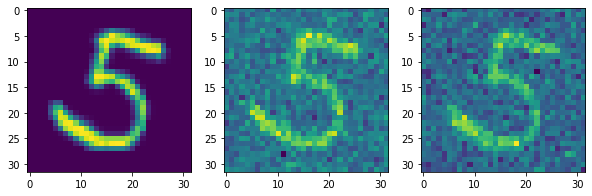

In [6]:
for idx,(data,target) in enumerate(train_loader):
  # data = data.flatten(start_dim =1)
  # print(data.shape)
  # data = data.reshape(data.shape[0],1,28,28)
  figure,ax = plt.subplots(1,3,figsize=(10,10))
  data2 = data
  data2 = data2.permute(0,2,3,1)
  party1 = data2[0].flatten(start_dim = 1)
  ax[0].imshow(party1)
  # plt.imshow(party1)
  # plt.show()
  
  data3 = data + torch.randn(data.shape)
  data3 = data3.permute(0,2,3,1)
  party2 = data3[0].flatten(start_dim = 1)
  # plt.imshow(party2)
  # plt.show()
  ax[1].imshow(party2)
  

  data1 = data + torch.randn(data.shape)
  data1 = data1.permute(0,2,3,1)
  party = data1[0].flatten(start_dim = 1)
  # plt.imshow(party)
  # plt.show()
  ax[2].imshow(party)

  plt.show()
  break

In [7]:
# defining models

class Encoder(nn.Module):
  def __init__(self,in_features=config['IMAGE_SIZE']*config['IMAGE_SIZE'],latent_features=config['latent_features']*config['latent_features']):
    super(Encoder,self).__init__()

    self.enc1 = nn.Linear(in_features=in_features,out_features=128)
    self.relu1 = nn.ReLU()
    self.enc2 = nn.Linear(in_features=128,out_features=64)
    self.relu2 = nn.ReLU()
    self.enc3 = nn.Linear(in_features=64,out_features=32)
    self.relu3 = nn.ReLU()
    self.latentfeaturevector = nn.Linear(in_features=32,out_features=latent_features)

  def forward(self,x):
    # x=> [B,1*28*28]
    x = self.relu1(self.enc1(x))
    x = self.relu2(self.enc2(x))
    x = self.relu3(self.enc3(x))
    x = self.latentfeaturevector(x)
    return x

class Decoder(nn.Module):
  def __init__(self,in_features=config['latent_features']*config['latent_features'],out_features=config['IMAGE_SIZE']*config['IMAGE_SIZE']):
    super(Decoder,self).__init__()
    self.dec1 = nn.Linear(in_features=in_features,out_features=32)
    self.relu1 = nn.ReLU()
    self.dec2 = nn.Linear(in_features=32,out_features=64)
    self.relu2 = nn.ReLU()
    self.dec3 = nn.Linear(in_features=64,out_features=128)
    self.relu3 = nn.ReLU()
    self.dec4 = nn.Linear(in_features=128,out_features=out_features)

  def forward(self,x):
    # x => [B,8*8]
    x = self.relu1(self.dec1(x))
    x = self.relu2(self.dec2(x))
    x = self.relu3(self.dec3(x))
    x = self.dec4(x)
    return x;

class AutoEncoder(nn.Module):
  def __init__(self,in_features=config['IMAGE_SIZE']*config['IMAGE_SIZE'],latent_feature=config['latent_features']*config['latent_features'],return_latent_features=False):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder(in_features,latent_feature)
    self.decoder = Decoder(latent_feature,out_features=in_features)
    self.return_latent_features = return_latent_features

  def forward(self,x):
    x = self.encoder(x)
    if (self.return_latent_features):
      return x
    x = self.decoder(x)
    return x

# ae = AutoEncoder(return_latent_features=True)
# print(ae)
# ae(torch.rand(2,1,config['IMAGE_SIZE']*config['IMAGE_SIZE'])).shape


In [8]:
def train(model,lossfunction,optimizer,n_epochs=200):
  tval = {'valloss':[],"trainloss":[]}
  starttime = time.time()
  for epochs in range(n_epochs):
      model.train()
      cur_loss = 0
      len_train = len(train_loader)
      for idx , (data,_) in enumerate(train_loader):
          data = transformations['train'](data)

          Ndata = data + torch.randn(data.shape)    
          data = data.flatten(start_dim = 1) # target - > [B,1*28*28]
          data = data.to(device)
          Ndata = Ndata.flatten(start_dim = 1)
          Ndata = Ndata.to(device)
          scores = model(Ndata)    
          loss = lossfunction(scores,data)
          cur_loss += loss.item() / (len_train)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          print('TrainBatchDone:{:d}'.format(idx),end='\r') 
  
      model.eval()

      valloss = 0
      for idx ,(data,_) in enumerate(validate_loader):
          
          data = transformations['val'](data)
          Ndata = data + torch.randn(data.shape)
          data = data.flatten(start_dim = 1)
          data = data.to(device)
          Ndata = Ndata.flatten(start_dim = 1)
          Ndata = Ndata.to(device)
          # model = model.to(device)
          with torch.no_grad():
              scores = model(data)
              loss = lossfunction(scores,data)
              valloss += loss.item() / len(validate_loader)
              # torch.cuda.empty_cache(self.gpu_id)

          print('ValidnBatchDone:{:d}'.format(idx),end='\r') 


      model.train()

      tval['valloss'].append(valloss)
      tval['trainloss'].append(cur_loss)
      
      print('epoch:[{:d}/{:d}], TrainLoss:{:.3f}, ValLoss:{:.3f}'.format(epochs+1,n_epochs,cur_loss,valloss)) 

  time2 = time.time() - starttime
  print('done time {:.3f} hours'.format(time2/3600))
  return tval

def getparams(model):
    total_parameters = 0
    for name,parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        total_parameters += param
    print(f"total_trainable_parameters are : {total_parameters}")

def loss_curve(tval):
  plt.plot(list(range(1,config['EPOCHS']+1)),tval['trainloss'],color='orange',label='train_loss')
  plt.plot(list(range(1,config['EPOCHS']+1)),tval['valloss'],color='blue',label='validation_loss')
  plt.legend()
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

def evaluate(model,loader,lossfunction,name='test'):
  model.eval()
  o_loss = 0
  with torch.no_grad():
      for idx,(x,y) in enumerate(loader):
          x = transformations['test'](x)
          Nx = x + torch.randn(x.shape)
          x = x.flatten(start_dim = 1)
          x = x.to(device)
          Nx = Nx.flatten(start_dim = 1)
          Nx = Nx.to(device)
          # model = model.to(device)

          scores = model(x)
          loss = lossfunction(scores,x)
          o_loss += (loss.item()/(len(loader)))
          print('batches done : ',idx,end='\r')

          if (idx <= 5):
            # Nx = Nx.reshape(Nx.shape[0],config['IMAGE_SIZE'],config['IMAGE_SIZE'])
            x = x.reshape(x.shape[0],config['IMAGE_SIZE'],config['IMAGE_SIZE'])
            fig,ax = plt.subplots(2,5,figsize=(12,4))
            for jdx,image in enumerate(x):
              # image = image.permute(1,2,0)
              # image = image.flatten(start_dim=1)
              image = image.to('cpu')
              ax[0][jdx].imshow(image)
              # plt.imshow(image)
              # plt.show()

              output = scores[jdx]
              output = output.reshape((config['IMAGE_SIZE'],config['IMAGE_SIZE']))
              output = output.to('cpu')
              # plt.imshow(output)
              # plt.show()
              ax[1][jdx].imshow(output)

              if (jdx == 4):
                break
            plt.show()
      
      print('loss: {:.2f}'.format(o_loss))
      
  model.train()
  return o_loss

total_trainable_parameters are : 288256


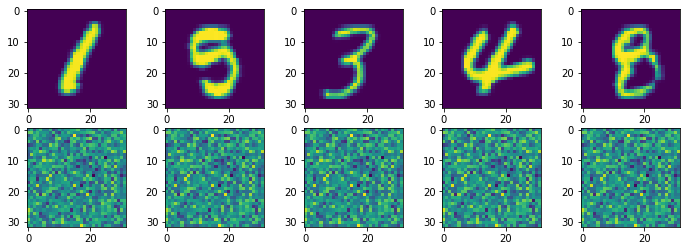

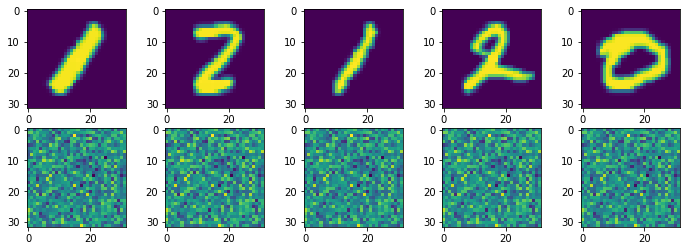

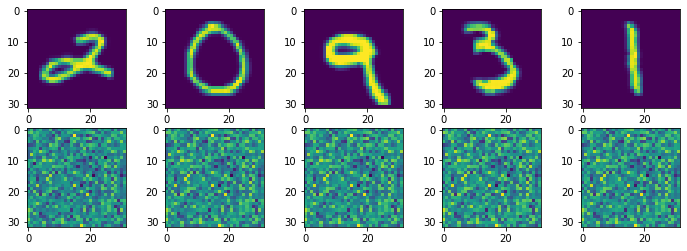

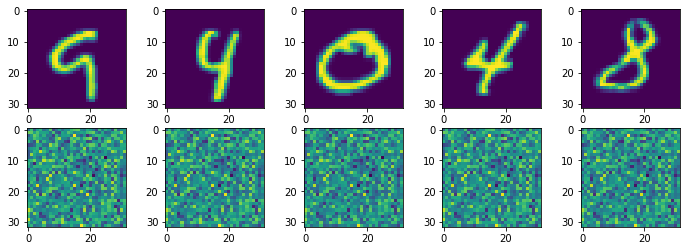

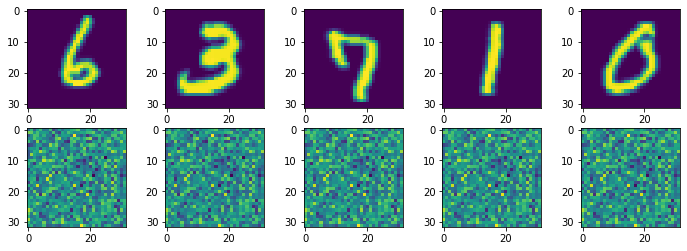

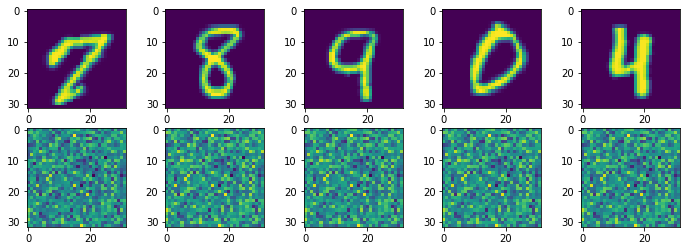

loss: 109.12 :  31280


In [9]:
torchmodel = AutoEncoder()
torchmodel = torchmodel.to(device)

lossfunction = nn.MSELoss()
optimizer = optim.Adam(params=torchmodel.parameters(),lr=config['lr'])
getparams(torchmodel)

test_loss1 = evaluate(torchmodel,test_loader,lossfunction,name='test')





In [10]:
history = train(torchmodel,lossfunction,optimizer,n_epochs=config['EPOCHS'])


epoch:[1/40], TrainLoss:16.767, ValLoss:11.340
epoch:[2/40], TrainLoss:9.458, ValLoss:8.509
epoch:[3/40], TrainLoss:7.773, ValLoss:7.214
epoch:[4/40], TrainLoss:6.862, ValLoss:6.488
epoch:[5/40], TrainLoss:6.285, ValLoss:6.031
epoch:[6/40], TrainLoss:5.893, ValLoss:5.676
epoch:[7/40], TrainLoss:5.641, ValLoss:5.513
epoch:[8/40], TrainLoss:5.394, ValLoss:5.333
epoch:[9/40], TrainLoss:5.236, ValLoss:5.124
epoch:[10/40], TrainLoss:5.061, ValLoss:4.959
epoch:[11/40], TrainLoss:4.924, ValLoss:4.833
epoch:[12/40], TrainLoss:4.825, ValLoss:4.795
epoch:[13/40], TrainLoss:4.758, ValLoss:4.757
epoch:[14/40], TrainLoss:4.686, ValLoss:4.650
epoch:[15/40], TrainLoss:4.621, ValLoss:4.568
epoch:[16/40], TrainLoss:4.555, ValLoss:4.517
epoch:[17/40], TrainLoss:4.469, ValLoss:4.357
epoch:[18/40], TrainLoss:4.401, ValLoss:4.385
epoch:[19/40], TrainLoss:4.356, ValLoss:4.306
epoch:[20/40], TrainLoss:4.318, ValLoss:4.288
epoch:[21/40], TrainLoss:4.281, ValLoss:4.204
epoch:[22/40], TrainLoss:4.259, ValLoss:4

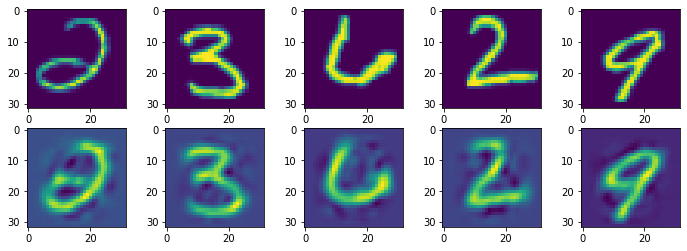

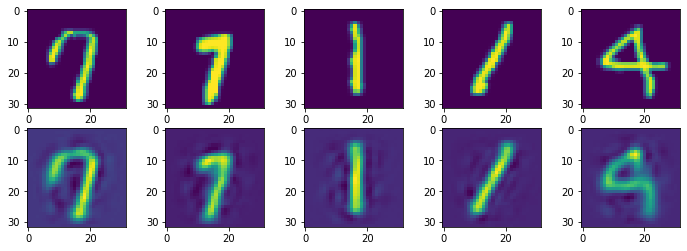

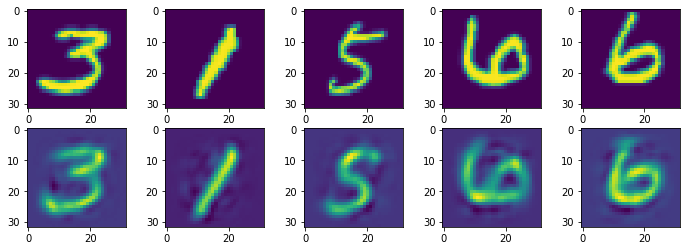

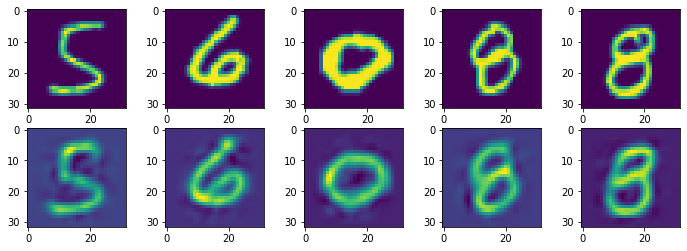

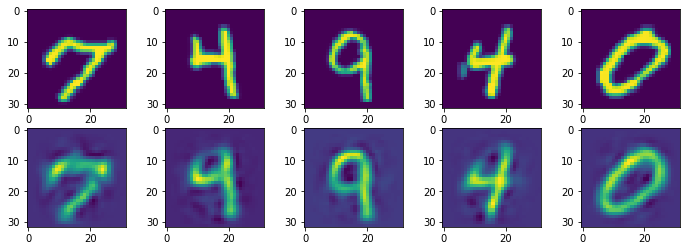

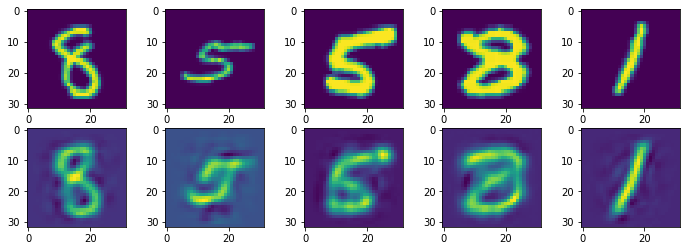

loss: 3.90ne :  312


In [11]:
test_loss = evaluate(torchmodel,test_loader,lossfunction,name='test')

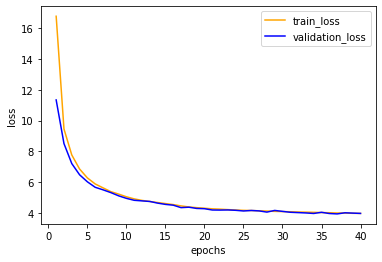

In [12]:
loss_curve(history)

In [15]:
def train_latent(model,lossfunction,optimizer,n_epochs=200):
  tval = {'valloss':[],'valacc':[],'trainacc':[],"trainloss":[]}
  starttime = time.time()
  for epochs in range(n_epochs):
    model.train()
    cur_loss = 0
    curacc = 0
    len_train = len(train_loader)
    for idx , (data,target) in enumerate(train_loader):
      data = transformations['train'](data)    
      data = data.to(device)
      target = target.to(device)
      # model = model.to(device)

      scores = model(data) 
      # print(scores.shape)  
      loss = lossfunction(scores,target)
      cur_loss += loss.item() / (len_train)
      scores = F.softmax(scores,dim = 1)
      _,predicted = torch.max(scores,dim = 1)
      correct = (predicted == target).sum()
      samples = scores.shape[0]
      curacc += correct / (samples * len_train)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print('TrainBatchDone:{:d}'.format(idx),end='\r') 

    model.eval()

    valacc = 0;valloss = 0
    for idx ,(data,target) in enumerate(validate_loader):
        
      data = transformations['val'](data)
      data = data.to(device)
      target = target.to(device)
      # model = model.to(device)

      correct = 0;samples=0
      with torch.no_grad():
        scores = model(data)
        loss = lossfunction(scores,target)
        scores =F.softmax(scores,dim=1)
        _,predicted = torch.max(scores,dim = 1)
        correct += (predicted == target).sum()
        samples += scores.shape[0]
        valloss += loss.item() / len(validate_loader)
        valacc += correct / (samples * len(validate_loader))
        # torch.cuda.empty_cache(self.gpu_id)

      print('ValidnBatchDone:{:d}'.format(idx),end='\r') 


    model.train()

    tval['valloss'].append(float(valloss))
    tval['valacc'].append(float(valacc))
    tval['trainacc'].append(float(curacc))
    tval['trainloss'].append(float(cur_loss))
    
    print('epoch:[{:d}/{:d}], TrainAcc:{:.3f}, TrainLoss:{:.3f}, ValAcc:{:.3f}, ValLoss:{:.3f}'.format(epochs+1,n_epochs,curacc,cur_loss,valacc,valloss)) 

  time2 = time.time() - starttime
  print('done time {:.3f} hours'.format(time2/3600))
  return tval

def loss_acc_curve(tval):
    figure,ax=plt.subplots(1,2,figsize=(18,5))
    ax[0].plot(list(range(1,config['TRAIN_EPOCHS']+1)),tval['trainloss'],color='orange',label='train_loss')
    ax[0].plot(list(range(1,config['TRAIN_EPOCHS']+1)),tval['valloss'],color='blue',label='validation_loss')
    ax[0].legend()
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
    ax[0].set_title('loss curve')
  # plt.show()

    ax[1].plot(list(range(1,config['TRAIN_EPOCHS']+1)),tval['trainacc'],color='orange',label='train_acc')
    ax[1].plot(list(range(1,config['TRAIN_EPOCHS']+1)),tval['valacc'],color='blue',label='validation_acc')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("accuracy")
    ax[1].legend()
    ax[1].set_title('accuracy curve')
    
    plt.show()

def plot_roc(fpr_tpr_auc): # name can be test train or validation
    plt.figure(figsize=(7,6))
    for i in range(10):
        fpr,tpr,aucc = fpr_tpr_auc[i]
        plt.plot(fpr,tpr,label = 'auc{:d}:{:.2f}'.format(i,aucc))
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.legend()
        plt.title('ROC')
    plt.show() 

def evaluate_latent(model,loader,name='test'):
  model.eval()
  correct = 0;samples =0
  fpr_tpr_auc = {}
  pre_prob = []
  lab = []
  predicted_labels = []

  with torch.no_grad():
      for idx,(x,y) in enumerate(loader):
          x = transformations['test'](x)
          x = x.to(device)
          y = y.to(device)
          # model = model.to(device)

          scores = model(x)
          predict_prob = F.softmax(scores)
          _,predictions = predict_prob.max(1)

          predictions = predictions.to('cpu')
          y = y.to('cpu')
          predict_prob = predict_prob.to('cpu')

          predicted_labels.extend(list(predictions.numpy()))
          pre_prob.extend(list(predict_prob.numpy()))
          lab.extend(list(y.numpy()))

          correct += (predictions == y).sum()
          samples += predictions.size(0)

          print('batches done : ',idx,end='\r')
      
      print('correct are {:.2f}'.format(correct/samples))
      
#     fpr_tpr_auc[f'fpr_{name}'], fpr_tpr_auc[f'tpr_{name}'], _ = roc_curve(lab,pre_prob[:,1])
#     fpr_tpr_auc[f'auc_{name}'] = auc(fpr_tpr_auc[f'fpr_{name}'],fpr_tpr_auc[f'tpr_{name}'])
  y_binarize = label_binarize(lab,classes=[i for i in range(10)])
  pre_prob = np.array(pre_prob)
  for i in range(10):
    fpr,tpr,_ = roc_curve(y_binarize[:,i],pre_prob[:,i])
    aucc = auc(fpr,tpr)
    fpr_tpr_auc[i] = [fpr,tpr,aucc]
  model.train()
  return fpr_tpr_auc
# for idx,(data,_) in enumerate(test_loader):
#   data = data.flatten(start_dim = 1)
#   data = data.to(device)
#   scores  = torchmodel(data)
#   for jdx in range(10):
#     to_print = data[jdx].reshape(config['IMAGE_SIZE'],config['IMAGE_SIZE'])
#     # print(scores[0].shape)
#     scores1 = scores[jdx].reshape(8,8)
#     # print(scores1.shape)
#     plt.imshow(to_print)
#     plt.show()
#     plt.imshow(scores1.detach().numpy())
#     plt.show()
#   break

Classify(
  (autoencoder): AutoEncoder(
    (encoder): Encoder(
      (enc1): Linear(in_features=1024, out_features=128, bias=True)
      (relu1): ReLU()
      (enc2): Linear(in_features=128, out_features=64, bias=True)
      (relu2): ReLU()
      (enc3): Linear(in_features=64, out_features=32, bias=True)
      (relu3): ReLU()
      (latentfeaturevector): Linear(in_features=32, out_features=64, bias=True)
    )
    (decoder): Decoder(
      (dec1): Linear(in_features=64, out_features=32, bias=True)
      (relu1): ReLU()
      (dec2): Linear(in_features=32, out_features=64, bias=True)
      (relu2): ReLU()
      (dec3): Linear(in_features=64, out_features=128, bias=True)
      (relu3): ReLU()
      (dec4): Linear(in_features=128, out_features=1024, bias=True)
    )
  )
  (fc1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_f

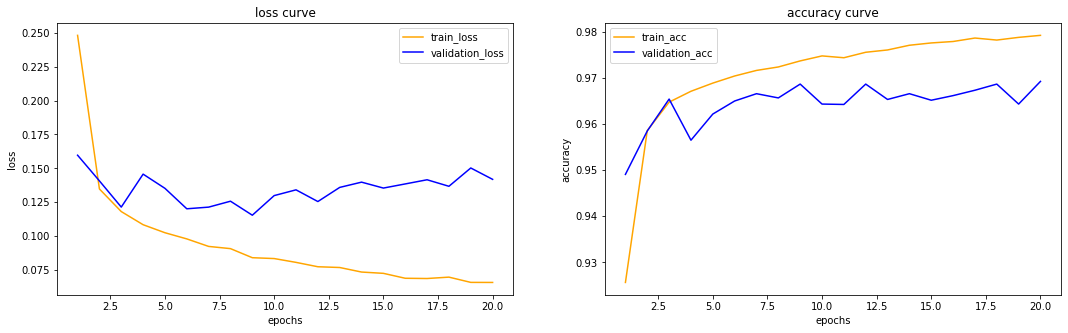

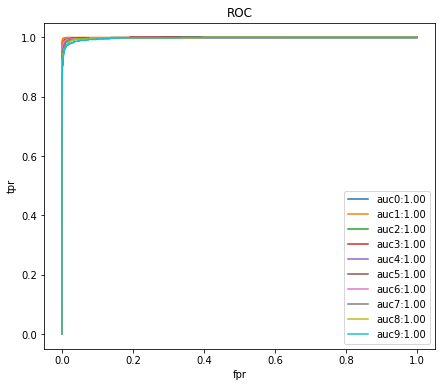

In [17]:
torchmodel.return_latent_features = True
for param in torchmodel.parameters():
  param.requires_grad = False

class Classify(nn.Module):
  def __init__(self,torchmodel=torchmodel,in_features=config['latent_features']*config['latent_features'],n_class = 10,fc=1):
    super(Classify,self).__init__()
    self.autoencoder = torchmodel
    self.fc = fc
    self.fc1 = nn.Sequential(
        nn.Linear(in_features=in_features,out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128,out_features=n_class)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(in_features=in_features,out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128,out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,out_features=n_class)
    )

  def forward(self,x):
    # x => [B,1,28,28] -> [B,1*28*28]
    x = x.flatten(start_dim=1)
    x = self.autoencoder(x)
    # x.shape = [B,64]
    if (self.fc == 1):
        x = self.fc1(x)
    else:
        x = self.fc2(x)
    return x # [B,10]

torchmodel_latent = Classify()
torchmodel_latent = torchmodel_latent.to(device)

print(torchmodel_latent)
lossfunction_latent = nn.CrossEntropyLoss()
optimizer_latent = optim.Adam(params=torchmodel_latent.parameters(),lr=config['lr'])

getparams(torchmodel_latent)
history = train_latent(torchmodel_latent,lossfunction_latent,optimizer_latent,n_epochs=config['TRAIN_EPOCHS'])
train_fta = evaluate_latent(torchmodel_latent,test_loader,name='test')

loss_acc_curve(history)
plot_roc(train_fta)

Classify(
  (autoencoder): AutoEncoder(
    (encoder): Encoder(
      (enc1): Linear(in_features=1024, out_features=128, bias=True)
      (relu1): ReLU()
      (enc2): Linear(in_features=128, out_features=64, bias=True)
      (relu2): ReLU()
      (enc3): Linear(in_features=64, out_features=32, bias=True)
      (relu3): ReLU()
      (latentfeaturevector): Linear(in_features=32, out_features=64, bias=True)
    )
    (decoder): Decoder(
      (dec1): Linear(in_features=64, out_features=32, bias=True)
      (relu1): ReLU()
      (dec2): Linear(in_features=32, out_features=64, bias=True)
      (relu2): ReLU()
      (dec3): Linear(in_features=64, out_features=128, bias=True)
      (relu3): ReLU()
      (dec4): Linear(in_features=128, out_features=1024, bias=True)
    )
  )
  (fc1): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_f

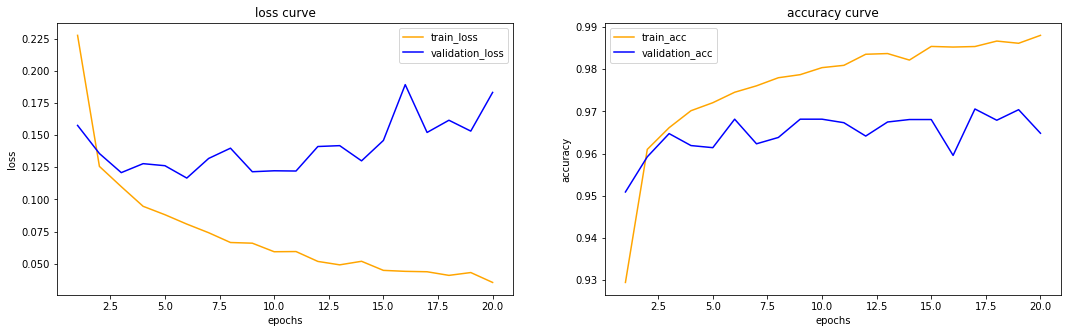

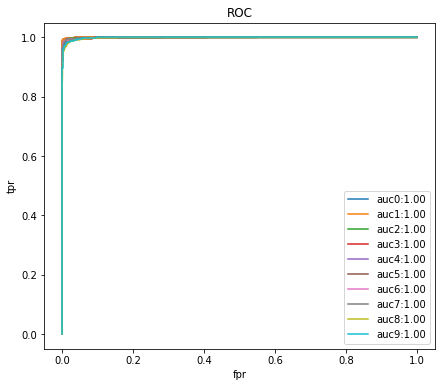

In [18]:
torchmodel_latent1 = Classify(fc=2)
torchmodel_latent1 = torchmodel_latent1.to(device)

print(torchmodel_latent1)
lossfunction_latent1 = nn.CrossEntropyLoss()
optimizer_latent1 = optim.Adam(params=torchmodel_latent1.parameters(),lr=config['lr'])

getparams(torchmodel_latent1)
history = train_latent(torchmodel_latent1,lossfunction_latent1,optimizer_latent1,n_epochs=config['TRAIN_EPOCHS'])
train_fta = evaluate_latent(torchmodel_latent1,test_loader,name='test')

loss_acc_curve(history)
plot_roc(train_fta)